In [1]:
# Set up the package development environment (e.g. after restarting kernel)
# pwd() should be "C:\\GitWorking\\Autologistic"
using Pkg  
Pkg.activate(pwd())   #At cmd line, could use ]activate .
using Revise
using Autologistic

┌ Info: Recompiling stale cache file C:\Users\krams\.julia\compiled\v0.7\Autologistic\Gemat.ji for Autologistic [05505b62-b0bd-11e8-1cec-1f3e16cbc293]
└ @ Base loading.jl:1185


In [3]:
# Run tests
include("test\\runtests.jl")

Running tests:
Test Summary:                         | Pass  Total
FullUnary constructors and interfaces |   11     11
Test Summary:                            | Pass  Total
LinPredUnary constructors and interfaces |    7      7
Test Summary:                              | Pass  Total
SimplePairwise constructors and interfaces |    5      5
Test Summary:        | Pass  Total
ALmodel constructors |    8      8
Test Summary:    | Pass  Total
Helper functions |    3      3
Test Summary:     | Pass  Total
almodel_functions |   11     11
Test Summary: | Pass  Total
samplers      |    2      2


Test.DefaultTestSet("samplers", Any[], 2, false)

## Try it out on retinitis pigmentosa data

I previously used the *retinitis pigmentosa* data set (available through https://sites.google.com/a/channing.harvard.edu/bernardrosner/channing/regression-method-when-the-eye-is-the-unit-of-analysis) in my MATH130146 lectures.  The data is in file `pigmentosa.csv`.

The response for each eye is **va**, an indicator of poor visual acuity (0 = no, 1 = yes).

The covariates (predictors) in the file are as follows:

* **aut_dom**: autosomal dominant (0=no, 1=yes)
* **aut_rec**: autosomal recessive (0=no, 1=yes)
* **sex_link**: sex-linked (0=no, 1=yes)
* **age**: age (years, range 6-80)
* **sex**: gender (0=female, 1=male)
* **psc**: posterior subscapsular cataract (0=no, 1=yes)
* **eye**: which eye is it? (0=left, 1=right)

The **ID** column is an ID specific to each patient.  Eyes with the same ID come from the same person.

For now, just consider **age**, **sex**, **psc**, and **eye** as covariates (plus intercept).  These data have only 2 observations per response, and there are 444 replicates (subjects). So $(n, p, m) = (2, 5, 444)$.

In this case, the individual replicates have only 2 observations.  So we should use full likelihood as I did in the lecture.  But for now we just want to test my ALR code and use pseudolikelihood.

In [17]:
# Load in the data.

using DataFrames, CSV
data_file_path = "C:\\MWProf\\Teaching\\MATH130146 - Statistical Modelling in Practice\\Lec9-LikelhoodExamples\\pigmentosa.csv"
df = CSV.read(data_file_path)
display(describe(df))
display(size(df))
head(df)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Float64,Int64,Float64,Int64,Nothing,Int64,DataType
1,ID,1569.22,7,1466.5,3392,,0,Int64
2,aut_dom,0.0990991,0,0.0,1,,0,Int64
3,aut_rec,0.141892,0,0.0,1,,0,Int64
4,sex_link,0.0608108,0,0.0,1,,0,Int64
5,age,34.2342,6,32.5,80,,0,Int64
6,sex,0.576577,0,1.0,1,,0,Int64
7,psc,0.432432,0,0.0,1,,0,Int64
8,eye,0.5,0,0.5,1,,0,Int64
9,va,0.504505,0,1.0,1,,0,Int64


(888, 9)

,ID,aut_dom,aut_rec,sex_link,age,sex,psc,eye,va
,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰
1,7,0,0,0,27,0,1,0,0
2,7,0,0,0,27,0,1,1,1
3,8,0,1,0,44,1,0,0,0
4,8,0,1,0,44,1,0,1,0
5,19,0,0,0,24,0,1,0,1
6,19,0,0,0,24,0,1,1,1


In [36]:
# Create an ALR model for this case.
# For i odd, records i and i+1 in df are for the same person.
# (age, sex, psc, eye) are in cols 5-8 of df.

X = Array{Float64,3}(undef, 2, 5, 444)
Y = Array{Float64,2}(undef, 2, 444)
for i in 1:2:888
    subject = Int((i+1)/2)
    X[1,:,subject] = [1 convert(Array, df[i,5:8])]
    X[2,:,subject] = [1 convert(Array, df[i+1,5:8])]
    Y[:,subject] = convert(Array, df[i:i+1, 9])
end

G = Graph(2,1)

Mod = ALRsimple(G, X, Y=Y, coding=(0,1))  # defaults to all zeros for β and λ

display(X)
display(Y)
display(getparameters(Mod))

2×5×444 Array{Float64,3}:
[:, :, 1] =
 1.0  27.0  0.0  1.0  0.0
 1.0  27.0  0.0  1.0  1.0

[:, :, 2] =
 1.0  44.0  1.0  0.0  0.0
 1.0  44.0  1.0  0.0  1.0

[:, :, 3] =
 1.0  24.0  0.0  1.0  0.0
 1.0  24.0  0.0  1.0  1.0

...

[:, :, 442] =
 1.0  34.0  1.0  0.0  0.0
 1.0  34.0  1.0  0.0  1.0

[:, :, 443] =
 1.0  45.0  1.0  1.0  0.0
 1.0  45.0  1.0  1.0  1.0

[:, :, 444] =
 1.0  34.0  0.0  1.0  0.0
 1.0  34.0  0.0  1.0  1.0

2×444 Array{Float64,2}:
 0.0  0.0  1.0  0.0  0.0  1.0  1.0  0.0  …  1.0  0.0  0.0  0.0  0.0  1.0  1.0
 1.0  0.0  1.0  0.0  0.0  1.0  1.0  0.0     1.0  1.0  0.0  1.0  0.0  0.0  1.0

6-element Array{Float64,1}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [37]:
# Try to optimize the parameters to minimize the (negative) pslikelihood.
using Optim

function PSLik(θ, M)
    setparameters!(M,θ)
    return pseudolikelihood(M)
end

@time out = optimize(θ -> PSLik(θ,Mod), zeros(6))


 39.322181 seconds (441.66 M allocations: 53.255 GiB, 13.61% gc time)


Results of Optimization Algorithm
 * Algorithm: Nelder-Mead
 * Starting Point: [0.0,0.0,0.0,0.0,0.0,0.0]
 * Minimizer: [-2.109840661397757,0.008257286548709337, ...]
 * Minimum: 3.842869e+02
 * Iterations: 308
 * Convergence: true
   *  √(Σ(yᵢ-ȳ)²)/n < 1.0e-08: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 517

In [38]:
round.(out.minimizer,digits=3)

6-element Array{Float64,1}:
 -2.11 
  0.008
  0.082
  0.258
  0.054
  3.308

In [39]:
# Try using fullPMF() to get the true likelihood
function negloglik(θ,M)
    setparameters!(M,θ)
    parts = fullPMF(M).partition
    return sum(log.(parts) - negpotential(M))
end

negloglik (generic function with 1 method)

In [40]:
# Do ML estimation
@time out = optimize(θ -> negloglik(θ,Mod), zeros(6))


 88.870409 seconds (1.08 G allocations: 121.301 GiB, 14.09% gc time)


Results of Optimization Algorithm
 * Algorithm: Nelder-Mead
 * Starting Point: [0.0,0.0,0.0,0.0,0.0,0.0]
 * Minimizer: [-2.1088577819423593,0.008046807446533667, ...]
 * Minimum: 4.928824e+02
 * Iterations: 345
 * Convergence: true
   *  √(Σ(yᵢ-ȳ)²)/n < 1.0e-08: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 568

In [42]:
round.(out.minimizer,digits=3)

6-element Array{Float64,1}:
 -2.109
  0.008
  0.08 
  0.271
  0.055
  3.308

In [54]:
using LinearAlgebra
function hess(fcn, x, h=1e-6)  # from MATH130146 lec 9
    # Approximate the Hessian of fcn at the point x, using a step width h.
    # Uses the O(h^2) central difference approximation.
    
    n = length(x)
    H = zeros(n,n)
    hI = h*Matrix(1.0I,n,n)  #ith column of hI has h in ith position, 0 elsewhere.
    
    # Fill up the top half of the matrix
    for i = 1:n        
        for j = i:n
            h1 = hI[:,i]
            h2 = hI[:,j];
            H[i,j] = (fcn(x+h1+h2)-fcn(x+h1-h2)-fcn(x-h1+h2)+fcn(x-h1-h2)) / (4*h^2)
        end
    end
    
    # Fill the bottom half of H (use symmetry), and return
    return H + LinearAlgebra.triu(H,1)'
end

hess (generic function with 2 methods)

In [56]:
@time H = hess(θ -> negloglik(θ,Mod), out.minimizer)
Hinv = inv(H)
SEs = sqrt.(LinearAlgebra.diag(Hinv))

 13.450702 seconds (160.37 M allocations: 17.942 GiB, 14.69% gc time)


6-element Array{Float64,1}:
 0.22540237678711092  
 0.0035968786162558558
 0.10691808561339358  
 0.11510051431778173  
 0.23892280372107097  
 0.26165197856474925  

In [19]:
function sample(M::ALmodel, k::Int=1; method::SamplingMethods=Gibbs, replicate::Int=1, 
                average::Bool=true, start=nothing, burnin::Int=0, verbose::Bool=false)
    if k < 1 error("k must be positive") end
    if replicate<1 || replicate>size(M.unary,2) 
        error("replicate must be between 1 and the number of replicates")
    end
    if burnin<0 error("burnin must be nonnegative") end
    lo = Float64(M.coding[1])
    hi = Float64(M.coding[2])
    Y = Vector{Float64}(vec(makecoded(M,M.responses[:,replicate])))
    Λ = M.pairwise[:,:,replicate]
    α = vec(M.unary[:,replicate])
    μ = vec(centering_adjustment(M)[:,replicate])
    n = length(α)
    if method==Gibbs
        if start==nothing
            start = Vector{Float64}(rand([M.coding[1] M.coding[2]], size(M.unary,1)))
        end
        return gibbssample(lo, hi, Y, Λ, α, μ, n, k, average, start, burnin, verbose)
    elseif method==perfect
        return perfectsample(M, k, replicate, average, verbose)
    end
end

function gibbssample(lo::Float64, hi::Float64, Y::Vector{Float64}, Λ::T, 
                     α::Vector{Float64}, μ::Vector{Float64}, n::Int, k::Int, average::Bool, 
                     start::Vector{Float64}, burnin::Int, verbose::Bool) where T<:AbstractMatrix
    temp = zeros(n, k)
    for j = 1:k
        for i = 1:n
            nbrsum = Λ[i,:]'*(Y-μ)
            etalo = exp(lo*(α[i] + nbrsum))
            etahi = exp(hi*(α[i] + nbrsum))
            p_i = ifelse(etahi==Inf, 1.0, etahi/(etalo + etahi))   #-handle rare overflows.
            Y[i] = ifelse(rand()<p_i, hi, lo)
        end
        temp[:,j] = Y
        if verbose println("finished draw $(j) of $(k)") end
    end
    out = ifelse(burnin==0, temp, temp[burnin+1:end])
    if average
        return sum(out.==hi,dims=2)/(k-burnin)
    else
        return out
    end
end

function perfectsample(M::ALmodel, k::Int, replicate::Int, average::Bool, verbose::Bool)

end


perfectsample (generic function with 1 method)

In [18]:
N = 25
MM = ALRsimple(grid4(N,N)[1], rand(N^2,1))
using Profile, ProfileView
Profile.clear()
@profile sample(MM)


┌ Info: Precompiling ProfileView [c46f51b8-102a-5cf2-8d2c-8597cb0e0da7]
└ @ Base loading.jl:1187


625×1 Array{Float64,2}:
 0.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 0.0
 1.0
 1.0
 1.0
 ⋮  
 1.0
 0.0
 1.0
 1.0
 0.0
 1.0
 0.0
 1.0
 0.0
 0.0
 1.0
 0.0

# Graph fooling

┌ Info: Recompiling stale cache file C:\Users\Mark\.julia\compiled\v0.7\GraphPlot\bUwXr.ji for GraphPlot [a2cc645c-3eea-5389-862e-a155d0052231]
└ @ Base loading.jl:1185


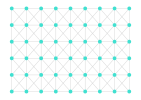

In [57]:
# Demonstrate graph8()
r = 6
c = 9
gg = grid8(r,c)
using GraphPlot
gplot(gg[1], [gg[2][i][1] for i in 1:r*c], [gg[2][i][2] for i in 1:r*c])

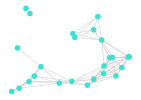

In [58]:
# Demonstrate spatialgraph() using random pts on unit square
nvert = 25
cutoff = 0.35
coords = [(rand(),rand()) for i in 1:nvert]
ggg = spatialgraph(coords, cutoff)
gplot(ggg[1], [ggg[2][i][1] for i in 1:nvert], [ggg[2][i][2] for i in 1:nvert])

In [61]:
# Try loading hydrocotyle data and making a graph.
using DataFrames, CSV
hydro = CSV.read("C:\\MWProf\\Data Sets\\ALRdata\\Hydrocotyle\\hydrocotyle.csv")
hydrocoords = [(hydro.X[i], hydro.Y[i]) for i in 1:size(hydro)[1]]
gr = spatialgraph(hydrocoords, sqrt(2))

(G = {2995, 5804} undirected simple Int64 graph, locs = Tuple{Int64,Int64}[(16, 1), (15, 2), (16, 2), (17, 2), (18, 2), (19, 2), (15, 3), (16, 3), (17, 3), (18, 3)  …  (34, 77), (43, 77), (44, 77), (26, 78), (27, 78), (28, 78), (31, 78), (32, 78), (33, 78), (27, 79)])

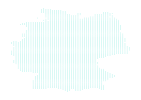

In [62]:
gplot(gr[1], [Float64(gr[2][i][1]) for i in 1:size(hydro)[1]], 
      [Float64(gr[2][i][2]) for i in 1:size(hydro)[1]],
      edgestrokec="black")


In [8]:
setparameters!(M4, [1.1,2.2,3.3,1.67]);
pars1 = getparameters(M4)
setunaryparameters!(M4, [4.4, 5.5, 6.6]);
pars2 = getparameters(M4)
setpairwiseparameters!(M4, [88.0]);
pars3 = getparameters(M4)
display([pars1 pars2 pars3])

4×3 Array{Float64,2}:
 1.1   4.4    4.4
 2.2   5.5    5.5
 3.3   6.6    6.6
 1.67  1.67  88.0